# **Deep Learning Prediction of Blood Glucose Sharp Peaks:** Optimization
## **Test**: Determine the Optimal Number of Training Epochs for Models

In [1]:
# Downloads
! pip install pymssql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 14.2 MB/s 


In [23]:
# Imports
import numpy as np
import pymssql
import pandas as pd
import matplotlib.pyplot as plt
from getpass import getpass
import datetime as dt
from datetime import timedelta
import time
from scipy.signal import savgol_filter, find_peaks
import time
import random as r
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
import matplotlib
from google.colab import drive

### **Part 1:** Set-Up of Dataset
*Contact Jack Lynn (jackrlynn@gmail.com) for log-in credentials.*

In [3]:
# Get dataset
def getData(database, table, server, port):

    # Get username and password
    username = input('Please enter username: ')
    password = getpass('Please enter password: ')

    conn = pymssql.connect(server,username,password,database)
    cursor = conn.cursor()
    query = f"SELECT * FROM {table}"
    df = pd.read_sql(query,conn)
    return df

df = getData("group5database", "dbo.GlucoseMeter",
             "gen10-data-fundamentals-22-05-sql-server.database.windows.net",
             "1433")

Please enter username: jacklynn
Please enter password: ··········


Text(0, 0.5, 'Blood Glucoose (mmol/L)')

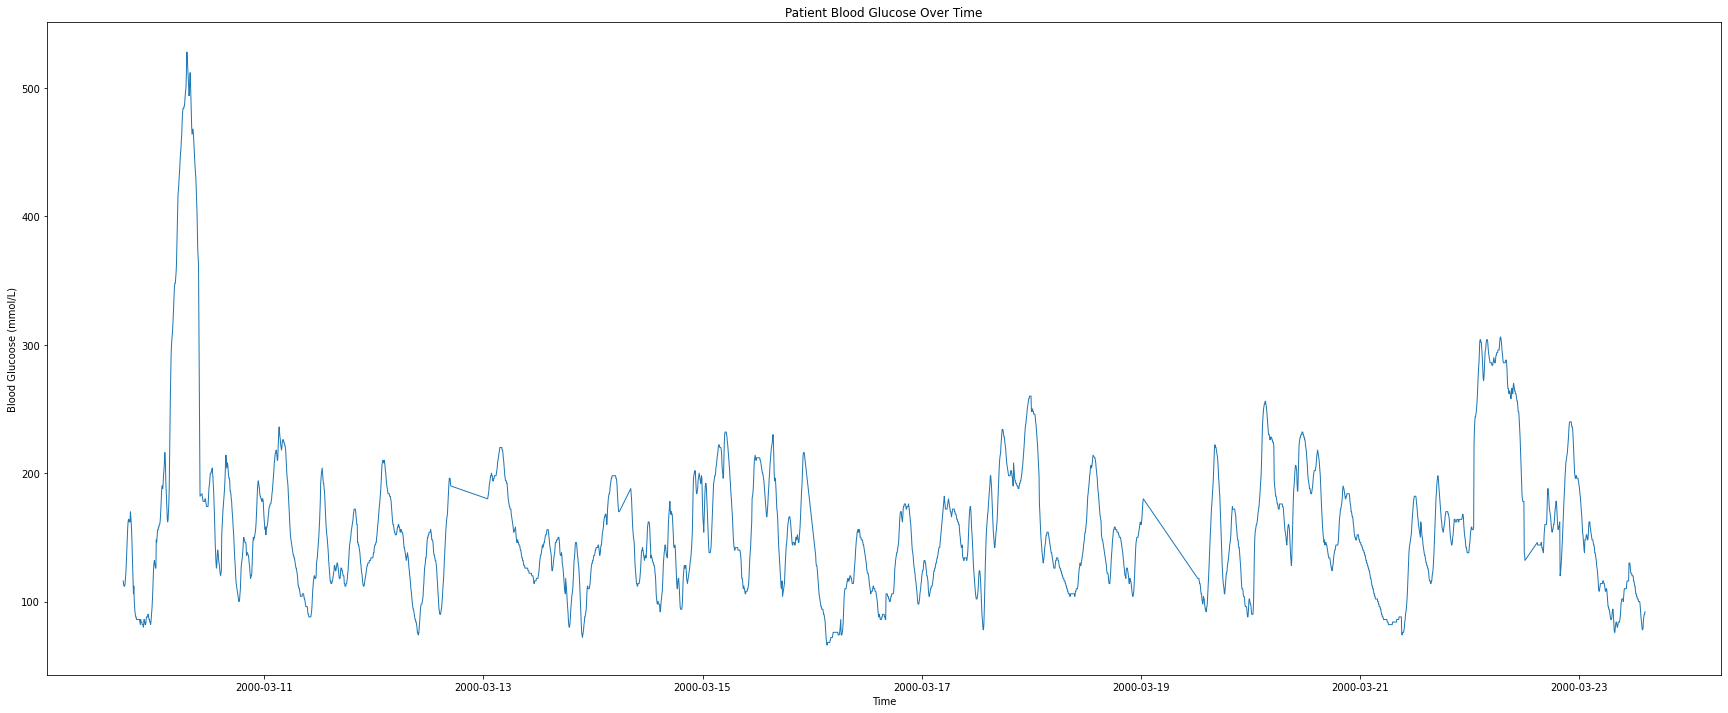

In [4]:
# Display static graphs
%matplotlib inline

# Get each patient
pts = dict()
for ptID in df['ptID'].unique():
  this_df = df[df['ptID'] == ptID]

  # Get only data related to time and glucose_lvl
  this_df = this_df[['time', 'glucose_lvl']]

  # Convert time back into dateime format
  this_df['time']= pd.to_datetime(this_df['time'])

  # Make sure time is in order
  this_df = this_df.sort_values('time')

  # Add patient to dictionary
  pts[ptID] = this_df

# Plot each patient on the same graph
fig, ax = plt.subplots(figsize=(30, 12))
ax.plot(pts[321]['time'], pts[321]['glucose_lvl'], LineWidth=1)
ax.set_title('Patient Blood Glucose Over Time')
ax.set_xlabel('Time')
ax.set_ylabel('Blood Glucoose (mmol/L)')

In [5]:
# Create list of individual DataFrames
df = pd.DataFrame()
for pt in pts.keys():

  # Format DataFrame
  this_df = pts[pt]
  this_df['pt'] = pt

  # Add to total DataFrame
  if (df.empty):
    df = this_df
  else:
    df = pd.concat([df, this_df], axis=0)

In [6]:
# Create models dictionary for saving tested models
models = dict()
predictions = dict()

In [7]:
# Split train and test
def splitXandY(df, test_prop=0.2):

  # Create train-test split
  df_test_pts = r.choices(df['pt'].unique(), k=int(test_prop*len(df['pt'].unique())))
  df_train_pts = list(filter(lambda x : x not in df_test_pts, df['pt'].unique()))
  df_test = df.loc[df['pt'].isin(df_test_pts)]
  df_train = df.loc[df['pt'].isin(df_train_pts)]

  # Return split
  return [df_train, df_test]

In [15]:
# Prepare the data
df_train, df_test = splitXandY(df)
minMax = MinMaxScaler(feature_range=(-1, 1))
df_train = df_train.drop(columns=['time', 'pt'])
df_test = df_test.drop(columns=['time', 'pt'])

### **Part 2:** Try Different Training Iterations

In [16]:
# Convert into 3D shape with window size preview
window = 30
X = []
y = []
y_unf = df_train['glucose_lvl'].to_list()
j = 0
for i in range(window, len(df_train)):
  X.append(df_train.iloc[(i-window):i])
  y.append([y_unf[i]])
X = np.array(X)
y = np.array(y)

In [18]:
# Convert into 3D shape with window size preview
window = 30
X_test = []
y_test = []
y_unf = df_test['glucose_lvl'].to_list()
j = 0
for i in range(window, len(df_test)):
  X_test.append(df_test.iloc[(i-window):i])
  y_test.append(y_unf[i])
X_test = np.array(X)
y_test = np.array(y)

In [19]:
# Initialize model
model_i = keras.models.Sequential()

# Add layers
model_i.add(keras.layers.LSTM(units=50, return_sequences=True,
                            input_shape=(X.shape[1], X.shape[2])))
model_i.add(keras.layers.Dense(25, activation='relu'))
model_i.add(keras.layers.Dropout(0.2))
model_i.add(keras.layers.LSTM(units=25, return_sequences=True))
model_i.add(keras.layers.Dense(10, activation='relu'))
model_i.add(keras.layers.Dropout(0.2))
model_i.add(keras.layers.LSTM(units=10, return_sequences=True))
model_i.add(keras.layers.Dense(5, activation='relu'))
model_i.add(keras.layers.Dropout(0.2))
model_i.add(keras.layers.LSTM(units=5, return_sequences=True))
model_i.add(keras.layers.Flatten())
model_i.add(keras.layers.Dense(1, activation='linear'))

# Compile model with optimizer and loss function
model_i.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

# Allow for early exit
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1,
                                   patience=10)

model_i.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 dense (Dense)               (None, 30, 25)            1275      
                                                                 
 dropout (Dropout)           (None, 30, 25)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 25)            5100      
                                                                 
 dense_1 (Dense)             (None, 30, 10)            260       
                                                                 
 dropout_1 (Dropout)         (None, 30, 10)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 10)            8

In [20]:
# Only go through training iteration (because loss can be extracted)

# Train model
model = keras.models.clone_model(model_i)
model.compile(optimizer='adam',
            loss='mean_squared_error',
            metrics=['mean_squared_error'])
m = model.fit(X, y, epochs=50, batch_size=500, callbacks=[es])

# Get prediction
y_pred = m.model.predict(X_test)

# Models
models[f'Training Time Model'] = m
predictions[f'Training Time Model'] = y_pred

Epoch 1/50
1258/1258 [==============================] - 33s 17ms/step - loss: 13694.1826 - mean_squared_error: 13694.1826
Epoch 2/50
1258/1258 [==============================] - 19s 15ms/step - loss: 5969.1704 - mean_squared_error: 5969.1704
Epoch 3/50
1258/1258 [==============================] - 18s 15ms/step - loss: 5907.7368 - mean_squared_error: 5907.7368
Epoch 4/50
1258/1258 [==============================] - 19s 15ms/step - loss: 2065.5220 - mean_squared_error: 2065.5220
Epoch 5/50
1258/1258 [==============================] - 19s 15ms/step - loss: 707.4709 - mean_squared_error: 707.4709
Epoch 6/50
1258/1258 [==============================] - 19s 15ms/step - loss: 483.4754 - mean_squared_error: 483.4754
Epoch 7/50
1258/1258 [==============================] - 19s 15ms/step - loss: 398.7186 - mean_squared_error: 398.7186
Epoch 8/50
1258/1258 [==============================] - 19s 15ms/step - loss: 335.3011 - mean_squared_error: 335.3011
Epoch 9/50
1258/1258 [========================

### **Part 3:** Visualize Results

Text(0, 0.5, 'Time to Train (s)')

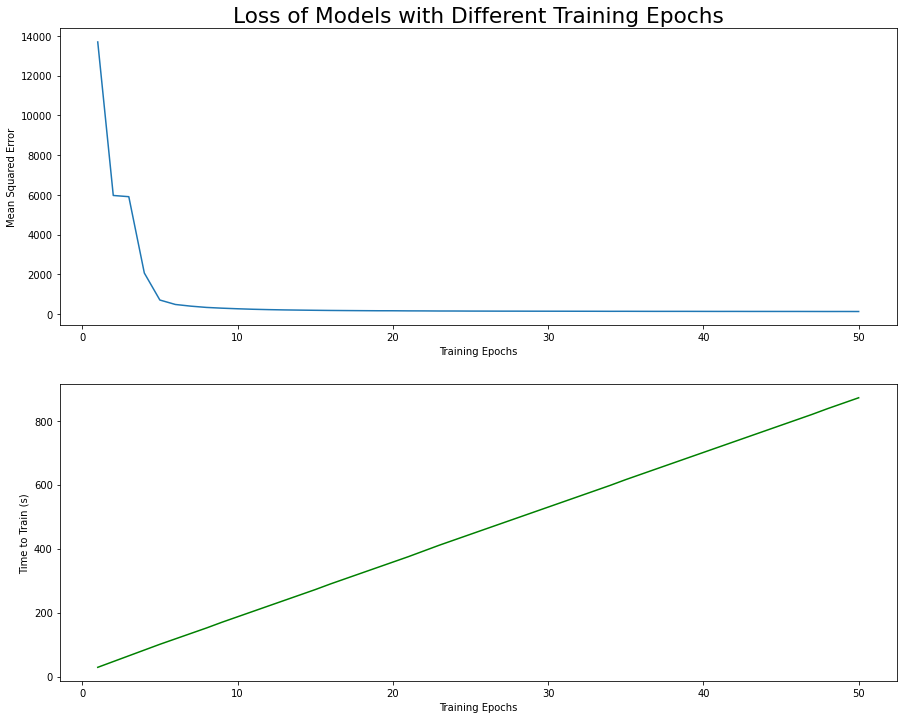

In [21]:
# Get loss
model = models['Training Time Model']
loss = []
loss_list = model.history['loss']
loss_int = len(loss_list) // 50
for i in range(loss_int - 1, len(loss_list), loss_int):
  loss.append(loss_list[i])

# Get training times (NOTE: this was taken from the first test!)
times_i = [29, 18, 18, 18, 18, 17, 17, 17, 18, 17, 17, 17, 17, 17, 17, 18, 17, 17,
        17, 17, 17, 18, 18, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 17, 17]
times = list(map(lambda i : sum(times_i[0:(i+1)]), range(len(times_i))))

# Get epochs
epochs = list(range(1, 51))

# Plot loss/time against training epoch
fig, axs = plt.subplots(2, figsize=(15, 12))

# Plot these values
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
axs[0].plot(epochs, loss)
axs[1].plot(epochs, times, color='green')

# Add in plot features
axs[0].set_title('Loss of Models with Different Training Epochs')
axs[0].set_xlabel('Training Epochs')
axs[0].set_ylabel('Mean Squared Error')
axs[1].set_xlabel('Training Epochs')
axs[1].set_ylabel('Time to Train (s)')

### **Part 4:** Save Model

In [22]:
# Prepare models
i = 1
for key in models.keys():
  model = models[key]
  model.model.save(f'training_test_{i}')
  i += 1

In [24]:
# Copy to drive
drive.mount('/content/drive')
!cp -r training_test_1/ "/content/drive/My Drive/"

Mounted at /content/drive
